**In this analysis, game data from a total of 2559 regular season NFL games covering a span of ten years from 2010-2019 is considered, obtained from http://pro-football-reference.com. The aim of this regression analysis is to predict the total points in a given NFL contest based on game conditions and statistics from the participating teams averaged over the previous six games. Only contests taking place from the seventh week of the season to the last week of the regular season are considered for prediction, totalling 1734 games. A description of the features used in this analysis follows.**

**Descriptive Features** - Used solely to describe the contest in question
 * Home_Team - The name of the home team in the contest
 * Vis_Team - The name of the visiting team in the contest
 * H_Game - The number of points scored by the home team in the contest
 * V_Game - The number of points scored by the visiting team in the contest
 
**Analytical Features** - Features used in analysis
 * Tot_Pts - Total Points of the contest. **This is our target variable.**
 * Over_Under - The predicted total points of the contest from professional bookmakers.
 
*Averaged Features* - Statistics averaged over previous five contests. In the columns, prefix "H_" stands for Home Team and "V_" stands for Visiting Team
 * Pts - Points scored
 * Pts_Opp - Points scored by opponent
 * Off_Pass - Offensive passing yards
 * Pass_Metric - Average of offensive passing rank (32 - best, 1 - worst) and defensive passing rank of opponent (1 - best, 32 - worst)
 * Off_Rush - Offensive rushing yards
 * Rush_Metric - Average of offensive rushing rank and defensive rushing rank of opponent
 * Def_Pass - Passing yards given up on defensive
 * Def_Rush - Rushing yards given up on defensive
 * TD - Touchdowns scored
 * TD_on_Def - Touchdowns scored by defense
 * FG_Pct - Percentage of field goals made vs. field goals attempted
 * RZ_Pct - Percentage of red zone possessions resulting in a touchdown (red zone possession is possession reaching opponent's 20 yard line)
 * Def_RZ_Pct - Defensive percentage of red zone possessions giving up a touchdown
 * Poss - Time of possession
 * Plays - Total number of plays
 * TO_Gain - Number of turnovers gained by defense
 * TO_Lost - Number of turnovers lost by offense
 * Yds_Pen - Number of yards penalized
 * Sacks_Def - Sacks earned by defense
 * Tackles_Loss - Number of tackles for loss earned by defense
 * Kickret - Return yards from kickoff
 * Puntret - Return yards from punt
 
*Game Conditions* - Conditions of the contest in question
 * Temperature - Temperature of the contest at kickoff
 * surface - The surface on which the contest was played

In [32]:
import warnings
warnings.filterwarnings("ignore")

In [33]:
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

In [34]:
sns.set(font_scale=1.4)

In [35]:
teams = {'Atlanta Falcons':'atl','Buffalo Bills':'buf','Carolina Panthers':'car','Chicago Bears':'chi',
         'Cincinnati Bengals':'cin','Cleveland Browns':'cle','Indianapolis Colts':'clt',
         'Arizona Cardinals':'crd','Dallas Cowboys':'dal','Denver Broncos':'den','Detroit Lions':'det',
         'Green Bay Packers':'gnb','Houston Texans':'htx','Jacksonville Jaguars':'jax',
         'Kansas City Chiefs':'kan','Miami Dolphins':'mia','Minnesota Vikings':'min','New Orleans Saints':'nor',
         'New England Patriots':'nwe','New York Giants':'nyg','New York Jets':'nyj','Tennessee Titans':'oti',
         'Philadelphia Eagles':'phi','Pittsburgh Steelers':'pit','Oakland Raiders':'rai',
         'St. Louis Rams':'ram','Baltimore Ravens':'rav','San Diego Chargers':'sdg','Seattle Seahawks':'sea',
         'San Francisco 49ers':'sfo','Tampa Bay Buccaneers':'tam','Washington Redskins':'was'}

In [36]:
num = 5 # number of games averaged over

In [37]:
import matplotlib as mpl
from matplotlib import cm

class MplColorHelper:

  def __init__(self, cmap_name, start_val, stop_val):
    self.cmap_name = cmap_name
    self.cmap = plt.get_cmap(cmap_name)
    self.norm = mpl.colors.Normalize(vmin=start_val, vmax=stop_val)
    self.scalarMap = cm.ScalarMappable(norm=self.norm, cmap=self.cmap)

  def get_rgb(self, val):
    return self.scalarMap.to_rgba(val)

In [38]:
def combine_dummies(df, name, combine_cols):
    for col in combine_cols:
        ind=df[df[col]==1].index
        df.loc[ind,name] = col
        df.drop(col,axis=1,inplace=True)
    return df

In [39]:
def colors_from_values(values, palette_name):
    # normalize the values to range [0, 1]
    normalized = (values - min(values)) / (max(values) - min(values))
    # convert to indices
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)

In [40]:
def weekofgame(game):
    from datetime import timedelta, datetime as dt
    day_of_week={2:0,3:1,4:2,5:3,6:4,0:5,1:6} #day of week starts on Wednesday
    date = dt.strptime(game[0:8],'%Y%m%d')
# .weekday() returns the day of the week for datetime.datetime   
    beg_week = date - timedelta(days=day_of_week[date.weekday()])
    fmt = lambda x: str(x) if x >= 10 else '0'+str(x)
    return(fmt(beg_week.month)+fmt(beg_week.day))

In [41]:
def get_year(code):
    if (code[4:6] == '01'):
        year = str(int(code[0:4])-1)
    else:
        year = str(int(code[0:4]))
    return year

In [42]:
def get_mapping(group,n):
    d={}
    keys = sorted(group['Week_Beg'].unique())
    values = [i for i in range((n+1),(n+1)+len(keys))]
    for key,value in zip(keys,values):
        d[key] = value
    return d

In [43]:
def bootstrap(data,n,func):
    n_replicates = 10000
    arr = np.empty(n_replicates)
    for i in range(n_replicates):
        rows = np.random.permutation(data.index)
        ind = data[rows[0:n]].index
        arr[i] = func(data[ind])
    return arr

In [44]:
def permutation_sample(data1, data2,random_state=None):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((data1,data2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

In [45]:
def diff_of_means(data1, data2):
    """Difference in means of two arrays."""

    # The difference of means of data1, data2: diff
    diff = np.mean(data1) - np.mean(data2)

    return diff

In [46]:
def permuted(data1, data2, func):
    n_replicates = 10000
    arr = np.empty(n_replicates)
    for i in range(n_replicates):
        perm1, perm2 = permutation_sample(data1,data2)
        arr[i] = func(perm1, perm2)
    return arr

In [47]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

In [48]:
path = 'data/df_2000_2009.pkl'
with open(path,'rb') as f:
    dfall = pickle.load(f)

In [49]:
path = 'data/df_2000_2009_5wk.pkl'
with open(path,'rb') as f:
    dfgame = pickle.load(f)

In [50]:
from sklearn.model_selection import train_test_split

train_ratio = 0.70
validation_ratio = 0.15
test_ratio = 0.15

X_show = dfgame.copy(deep=False)
X = dfgame.drop(['Tot_Pts','Over_Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
y = np.ravel(dfgame['Tot_Pts'])
# 70% split for training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1 - train_ratio, random_state = 77)
# 15%, 15% split for validation, test data
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, 
                                                test_size = test_ratio/(test_ratio + validation_ratio),
                                                random_state = 77)
X_show = X_show.loc[X_train.index]

In [51]:
import matplotlib
matplotlib.rcParams.update({'font.size': 14})

**The barplot demonstrates the quantized nature of football scoring. The significant advantage of the home team is indicated in the scoring as well as in the pie chart.** 

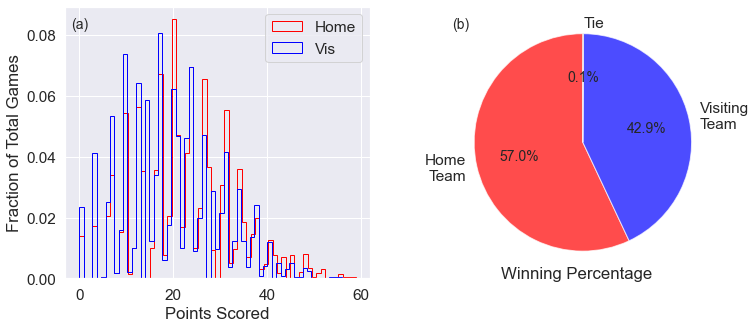

In [52]:
scores = dfall[['H_Game','V_Game']].rename({'H_Game':'Home','V_Game':'Vis'},axis=1)
fig1 = plt.figure(figsize=(12,5))
ax1 = plt.subplot(1,2,1)
_ = plt.xlabel('Points Scored',fontsize='large')
_ = plt.ylabel('Fraction of Total Games',fontsize='large')
_ = plt.hist(scores['Home'],bins=63,density=True,histtype='step',ec='red',alpha=1.0,
         label='Home')
_ = plt.hist(scores['Vis'],bins=60,density=True,histtype='step',ec='blue',alpha=1.0,
         label='Vis')
_ = plt.legend(loc='upper right')
ax1.text(0.02,0.92,'(a)',transform=ax1.transAxes)
ax2 = plt.subplot(1,2,2)
win = np.array([(scores['Home'] > scores['Vis']).sum(),(scores['Home'] < scores['Vis']).sum(),
                 (scores['Home'] == scores['Vis']).sum()])
labels = 'Home'+'\n'+'Team', 'Visiting'+'\n'+'Team', 'Tie'
colors = ('red','blue','black')
alpha = 0.7
p = plt.pie(win/sum(win),labels=labels,autopct='%1.1f%%',radius=1.0,colors=colors,startangle=90)
for i in range(3):
    p[0][i].set_alpha(alpha)
_ = plt.text(0.20,0.00,'Winning Percentage',transform=ax2.transAxes,fontsize='large')
ax2.text(0.02,0.92,'(b)',transform=ax2.transAxes)
fig1.show()


**We can see the range of total score is much larger than that of the Over/Under (3X) with a positive correlation of 0.28.**

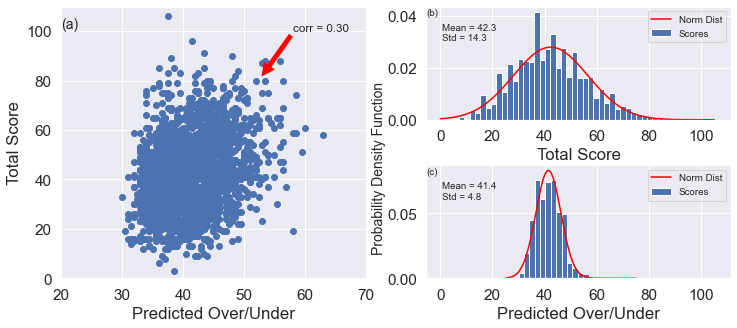

In [53]:
import matplotlib.gridspec as gridspec
from scipy import stats   

fig2 = plt.figure(figsize=(12,5))
outer = gridspec.GridSpec(1, 2, wspace=0.2, hspace=0.2)

inner_l = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[0])
ax = plt.Subplot(fig2, inner_l[0])
ax.scatter(dfall['Over_Under'],dfall['Tot_Pts'])
ax.set_xlim((20,70))
ax.set_ylim((0,110))
ax.set_xlabel('Predicted Over/Under')
ax.set_ylabel('Total Score')
corr = dfall['Tot_Pts'].corr(dfall['Over_Under'])
ax.annotate('corr = {:.2f}'.format(corr),xy=(53,82),xytext=(58,100),arrowprops={'color':'red'},fontsize='small')
ax.text(0.00,0.92,'(a)',transform=ax.transAxes)

fig2.add_subplot(ax)

inner_r = gridspec.GridSpecFromSubplotSpec(2, 1,subplot_spec=outer[1],hspace=0.4)
j=0
mu = np.mean(dfall['Tot_Pts'])
sig = np.std(dfall['Tot_Pts'])
ax0 = plt.Subplot(fig2, inner_r[j])
ax0.set_xlabel('Total Score')
ax0.hist(dfall['Tot_Pts'],bins=50,density=True,label='Scores')
xx = np.linspace(0,105,1000)
yy = stats.norm.pdf(xx,loc=mu,scale=sig)
ax0.plot(xx,yy,color='red',label='Norm Dist')
ax0.legend(loc='upper right',fontsize='x-small')
ax0.text(0.05,0.7,'Mean = {0:.1f}\nStd = {1:.1f}'.format(mu,sig),transform=ax0.transAxes,fontsize='x-small')
ax0.text(0.00,0.92,'(b)',transform=ax0.transAxes,fontsize='x-small')
fig2.add_subplot(ax0)
j=1
mu = np.mean(dfall['Over_Under'])
sig = np.std(dfall['Over_Under'])
ax1 = plt.Subplot(fig2, inner_r[j], sharex=ax0)
ax1.hist(dfall['Over_Under'],bins=16,density=True,label='Scores')
xx = np.linspace(25,75,500)
yy = stats.norm.pdf(xx,loc=np.mean(dfall['Over_Under']),scale=np.std(dfall['Over_Under']))
ax1.plot(xx,yy,color='red',label='Norm Dist')
ax1.legend(loc='upper right',fontsize='x-small')
ax1.text(0.05,0.7,'Mean = {0:.1f}\nStd = {1:.1f}'.format(mu,sig),transform=ax1.transAxes,fontsize='x-small')
ax1.text(0.00,0.92,'(c)',transform=ax1.transAxes,fontsize='x-small')
fig2.add_subplot(ax1)
fig2.text(0.485,0.20,'Probability Density Function',rotation='vertical')
ax1.set_xlabel('Predicted Over/Under')
fig2.show()


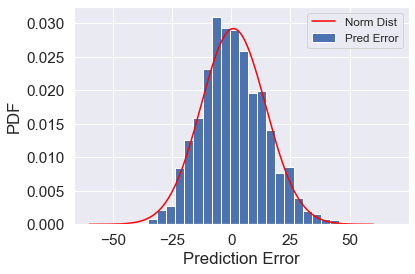

In [54]:
error = dfall['Tot_Pts'] - dfall['Over_Under']

mu = np.mean(error)
sig = np.std(error)
xx = np.linspace(-60,60,500)
yy = stats.norm.pdf(xx,loc=mu,scale=sig)
fig3 = plt.figure()
_ = fig3.add_subplot(1,1,1)
_ = plt.xlabel('Prediction Error')
_ = plt.ylabel('PDF')
_ = plt.hist(error,bins=28,density=True,label='Pred Error')
_ = plt.plot(xx,yy,color='red',label='Norm Dist')
_ = plt.legend(loc='upper right',fontsize='small')
fig3.show()


**This boxplot shows the symmetry of the error data around 0 and the larger number of positive outliers in the Over/Under prediction error.** 

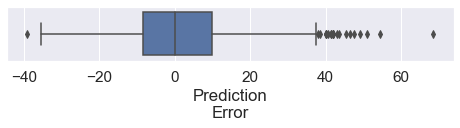

In [55]:
fig4 = plt.figure(figsize=(8,1))
error = pd.Series(error,name='Prediction'+'\n'+'Error')
_ = sns.boxplot(error, orient='h')
fig4.show()


**There is remarkable symmetry in the Over/Under prediction error, as well as in the Over vs. Under wins. This symmetry is also revealed in the median error, although a greater number of outliers to the upside is reflected in the average error.** 

The median and average errors for the Over are 10.0 and 12.1 points
The median and average errors for the Under are -8.5 and -10.0 points


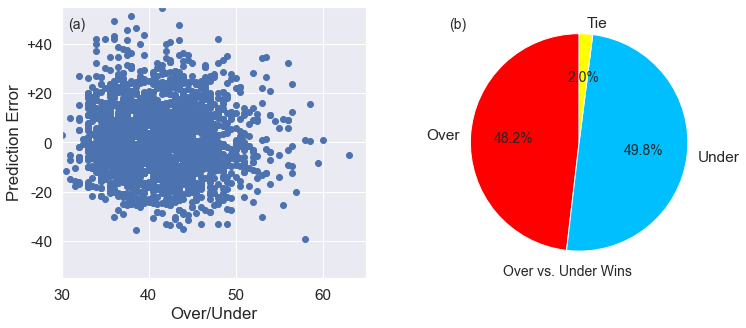

In [56]:
import matplotlib.ticker as tick
fig5, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5)) 
error = dfall['Tot_Pts'] - dfall['Over_Under']
ax1.set_ylim(-55,55)
ax1.set_xlim(30,65)
ax1.set_xlabel('Over/Under')
ax1.set_ylabel('Prediction Error')
ax1.scatter(dfall['Over_Under'],error)
def y_tk_fmt(x,y):
    if x > 0:
        return '{:+d}'.format(int(x))
    else:
        return '{:d}'.format(int(x))
ax1.yaxis.set_major_formatter(tick.FuncFormatter(y_tk_fmt))
ax1.text(0.02,0.92,'(a)',transform=ax1.transAxes,fontsize='medium')
o_u = np.array([(dfall['Tot_Pts'] > dfall['Over_Under']).sum(),
                (dfall['Tot_Pts'] < dfall['Over_Under']).sum(),
                 (dfall['Tot_Pts'] == dfall['Over_Under']).sum()])
labels = 'Over','Under','Tie'
colors = ('red','deepskyblue','yellow')
ax2.pie(o_u/sum(o_u),labels=labels,autopct='%1.1f%%',radius=1.0,colors=colors,
        startangle=90)
ax2.text(0.22,0.01,'Over vs. Under Wins',transform=ax2.transAxes)
ax2.text(0.02,0.92,'(b)',transform=ax2.transAxes,fontsize='medium')
fig5.show()
fig5.savefig('plots/fig5.png',bbox_inches='tight')
import statistics
pos = error[error > 0]
neg = error[error < 0]
print('The median and average errors for the Over are {0:.1f} and {1:.1f} points'
      .format(pos.median(),pos.mean()))
print('The median and average errors for the Under are {0:.1f} and {1:.1f} points'
      .format(neg.median(),neg.mean()))

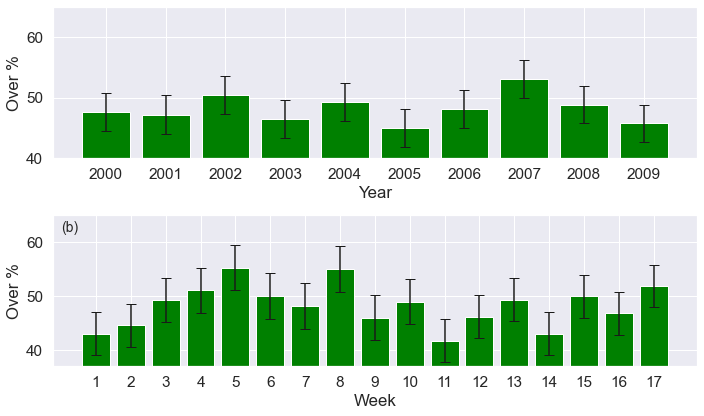

In [57]:
Q3=error.quantile(0.75)
Q1=error.quantile(0.25)
IQR = Q3-Q1
outliers = dfall.loc[error > 1.5*IQR,:]
outlier_year = pd.Series([get_year(x) for x in outliers.index])
year_counts = outlier_year.value_counts().sort_index()

# Calculate percentage of 'Overs' by year 
year = pd.DataFrame(index=dfall.index,columns=['Year'])
for ind in dfall.index: 
    year.loc[ind,'Year'] = int(get_year(ind))
    year.loc[ind,'Team'] = ind[-3:]
year['Over'] = dfall['Tot_Pts'] > dfall['Over_Under']
over_count_year = year['Over'].groupby(year.Year).mean()
year['Week'] = dfall['Week']
over_count_week = year['Over'].groupby(year.Week).mean()

fig6 = plt.figure(figsize=(10,6))
_ = fig6.add_subplot(2,1,1)
_ = plt.xlabel('Year')
_ = plt.ylabel('Over %')
x = year_counts.index
err = 100*np.sqrt(0.5*0.5/year['Over'].groupby(year.Year).count())
_ = plt.bar(x,over_count_year.values*100,color='green',yerr=err,capsize=5,
       tick_label=[str(i) for i in range(2000,2010)])
_ = plt.ylim(40,65)
_ = fig6.add_subplot(2,1,2)
_ = plt.xlabel('Week')
_ = plt.ylabel('Over %')
err = 100*np.sqrt(0.5*0.5/year['Over'].groupby(year.Week).count())
_ = plt.bar(range(1,18),over_count_week.values*100,color='green',yerr=err,capsize=5,
       tick_label=[str(i) for i in range(1,18)])
#_ = plt.errorbar()
_ = plt.ylim(37,65)
_ = plt.text(0.01,62,'(b)',fontsize='medium')
fig6.tight_layout()  
fig6.show()

**There is a significant difference in the Over % in Weeks 1-10 versus Weeks 11-17.** 

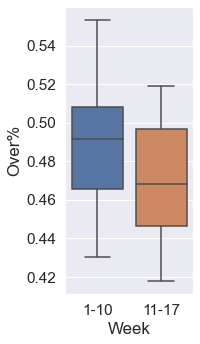

In [58]:
data = pd.DataFrame(over_count_week.values,columns=['Over%'])
data.loc[0:9,'Week'] = '1-10'
data.loc[10:16,'Week'] = '11-17'

fig7 = plt.figure(figsize=(3,5))
_ = fig7.add_subplot(1,1,1)
_ = sns.boxplot(x='Week',y='Over%',data=data,orient='v')
plt.tight_layout()
plt.show()

Confidence interval for Weeks 1-10 is (0.41875, 0.5625)
Confidence interval for Weeks 11-17 is (0.4, 0.54375)


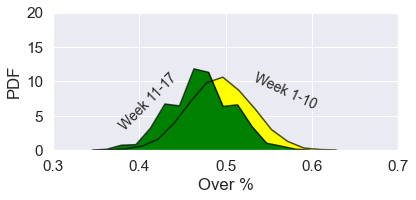

In [59]:
early = dfall[dfall['Week'] <= 10]
late = dfall[dfall['Week'] >= 10]
early_over_means=bootstrap(early['Tot_Pts']>early['Over_Under'],160,np.mean)
late_over_means=bootstrap(late['Tot_Pts']>late['Over_Under'],160,np.mean)

print('Confidence interval for Weeks 1-10 is {}'.format((np.percentile(early_over_means,2.5),np.percentile(early_over_means,97.5))))
print('Confidence interval for Weeks 11-17 is {}'.format((np.percentile(late_over_means,2.5),np.percentile(late_over_means,97.5))))

fig = plt.figure(figsize=(6,3))
_ = fig.add_subplot(1,1,1)
bins=16
n,x = np.histogram(early_over_means,bins=bins,density=True)
bin_centers = 0.5*(x[1:]+x[:-1])
plt.plot(bin_centers,n,color='black',alpha=0.7) ## using bin_centers rather than edges
plt.fill_between(bin_centers,n,color='yellow')

n,x = np.histogram(late_over_means,bins=bins,density=True)
#_ = plt.hist(late_over_means,bins=15,density=True)
bin_centers = 0.5*(x[1:]+x[:-1])
plt.plot(bin_centers,n,color='black',alpha=0.7) ## using bin_centers rather than edges
plt.fill_between(bin_centers,n,color='green')
_ = plt.ylim(0,20)
_ = plt.text(0.375,3,'Week 11-17',rotation=45)
_ = plt.text(0.53,6,'Week 1-10',rotation=335)
_ = plt.xlim(0.3,0.7)
_ = plt.xlabel('Over %')
_ = plt.ylabel('PDF')
fig.tight_layout()
plt.show()

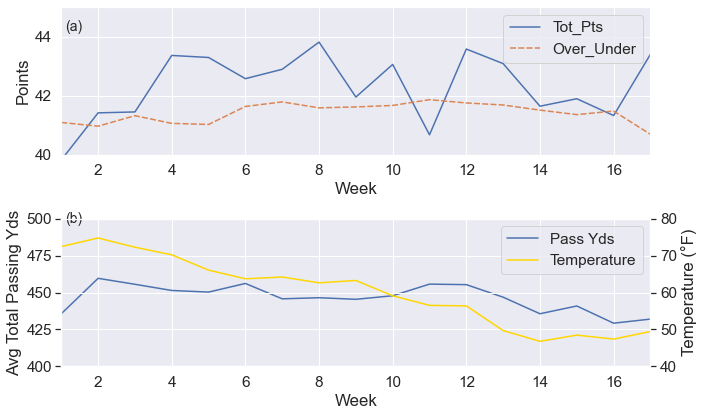

In [64]:
pyds = dfall[['H_Off_Pass','V_Off_Pass','Wind','Temperature','Week']].rename({'H_Off_Pass':'Home_Pass_Yds',
                                                                              'V_Off_Pass':'Vis_Pass_Yds'},axis=1)
pyds['Tot_Pass_Yds'] = pyds['Home_Pass_Yds'] + pyds['Vis_Pass_Yds']
for col in pyds.columns: pyds[col]=pd.to_numeric(pyds[col])

wind_by_week = pyds['Wind'].groupby(pyds.Week).mean()
temp_by_week = pyds['Temperature'].groupby(pyds.Week).mean()

tp=dfall[['Tot_Pts','Over_Under','Week']]
tp['Pass_Yds'] = dfall['H_Off_Pass'] + dfall['V_Off_Pass']
tp['Rush_Yds'] = dfall['H_Off_Rush'] + dfall['V_Off_Rush']
tpmelt=pd.melt(tp,id_vars=['Week'],value_vars=['Tot_Pts','Over_Under','Pass_Yds','Rush_Yds'],
              var_name='Feature')
tppivot=pd.pivot_table(tp,index=['Week'],values=['Tot_Pts','Over_Under','Pass_Yds','Rush_Yds'],aggfunc='mean')


fig8 = plt.figure(figsize=(10,6))
_ = fig8.add_subplot(2,1,1)
_ = sns.lineplot(data=tppivot[['Tot_Pts','Over_Under']])
_ = plt.xlim(1,17)
_ = plt.ylim(40,45)
_ = plt.ylabel('Points')
_ = plt.text(1.1,44.2,'(a)',fontsize='medium')
ax1 = fig8.add_subplot(2,1,2)
ax1.plot(tppivot.index,tppivot['Pass_Yds'],label='Pass Yds')
ax1.set_xlabel('Week')
ax1.set_ylabel('Avg Total Passing Yds')
ax1.text(1.1,497,'(b)',fontsize='medium')
ax1.set_ylim(400,500)
ax1.set_xlim(1,17)
ax2 = ax1.twinx()
ax2.plot(range(1,18),temp_by_week,color='gold',label='Temperature')
ax2.set_ylabel('Temperature (°F)')
ax2.set_ylim(40,80)
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')
fig8.tight_layout()  
fig8.show()


In [88]:
import pingouin as pg
early = dfall[dfall['Week'] < 11]
late = dfall[dfall['Week'] >= 11]
res = pg.ttest(early['Tot_Pts']>early['Over_Under'],late['Tot_Pts']>late['Over_Under'],
               correction=True,tail='greater')
print(res)

               T          dof     tail     p-val         CI95%   cohen-d  \
T-test  1.005898  2378.846482  greater  0.157284  [-0.01, inf]  0.040223   

         BF10     power  
T-test  0.149  0.261275  


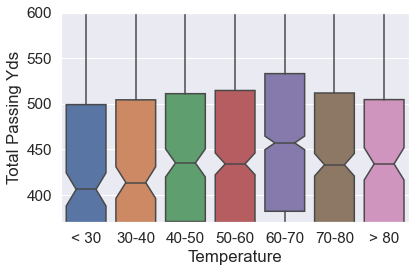

In [89]:
fig9 = plt.figure(figsize=(6,4))
_ = fig9.add_subplot(1,1,1)
bins = [-10,30,40,50,60,70,80,100]
pyds['Bin'] = pd.cut(pyds.Temperature,bins)
sns.boxplot(x='Bin',y='Tot_Pass_Yds',data=pyds,
            notch=True).set(xlabel='Temperature',ylim=(370,600),
                            ylabel='Total Passing Yds',xticklabels=['< 30','30-40','40-50','50-60','60-70','70-80','> 80'])
plt.tight_layout()
plt.show()


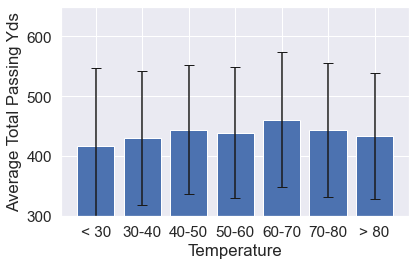

In [90]:
fig = plt.figure(figsize=(6,4))
_ = fig.add_subplot(1,1,1)
bins = [-10,30,40,50,60,70,80,100]
grouped = pyds.groupby(pd.cut(pyds.Temperature,bins))
ind = np.arange(len(grouped))
err = grouped['Tot_Pass_Yds'].std().values
_ = plt.bar(ind,grouped['Tot_Pass_Yds'].mean().values,yerr=err,capsize=5)
_ = plt.xticks(ind,labels=('< 30','30-40','40-50','50-60','60-70','70-80','> 80'))
_ = plt.ylim(300,650)
_ = plt.ylabel('Average Total Passing Yds')
_ = plt.xlabel('Temperature')
plt.tight_layout()
plt.show()

   **The variation in wind, temperature, and humidity by week are shown below.**

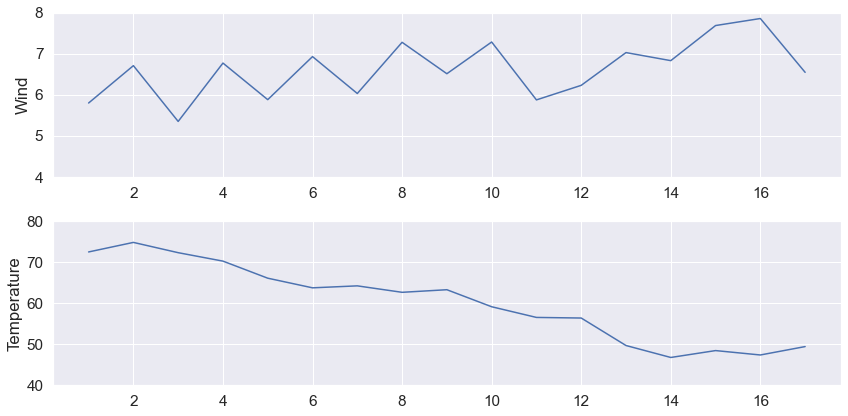

In [91]:
fig = plt.figure(figsize=(12,6))
_ = fig.add_subplot(2,1,1)
_ = plt.plot(range(1,18),wind_by_week)
_ = plt.ylim(4,8)
_ = plt.ylabel('Wind')
_ = fig.add_subplot(2,1,2)
_ = plt.plot(range(1,18),temp_by_week)
_ = plt.ylabel('Temperature')
_ = plt.ylim(40,80)
fig.tight_layout()  
fig.show()

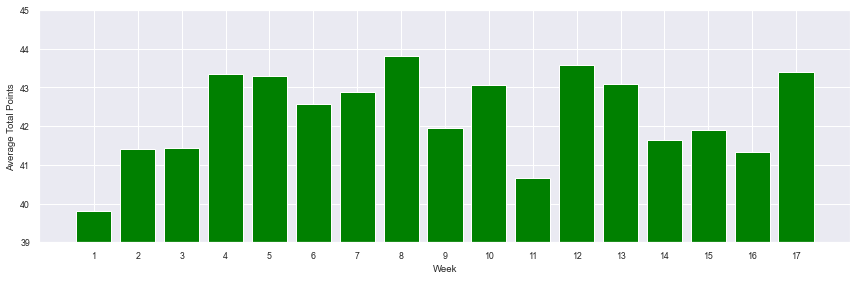

In [101]:
by_week = dfall[['Tot_Pts','Temperature']]
for ind in by_week.index: 
    by_week.loc[ind,'Week_Beg'] = weekofgame(ind)
    by_week.loc[ind,'Year'] = get_year(ind)
grouped_by_year = by_week.groupby(by_week['Year'])
for key, item in grouped_by_year:
    mapping = get_mapping(item,1)
    for code in item.index:
        by_week.loc[code,'Week'] = int(mapping[by_week.loc[code,'Week_Beg']])
by_week['Week'] = by_week['Week'].astype('int')

avg_pts_week = by_week['Tot_Pts'].groupby(by_week['Week']).mean()
std_pts_week = by_week['Tot_Pts'].groupby(by_week['Week']).std()
avg_temp_week = by_week['Temperature'].groupby(by_week['Week']).mean()

fig = plt.figure(figsize=(12,4))
_ = fig.add_subplot(1,1,1)
_ = plt.xlabel('Week')
_ = plt.ylabel('Average Total Points')
_ = plt.ylim(39,45)
_ = plt.bar(avg_pts_week.index,avg_pts_week.values,color='green',
       tick_label=[str(i) for i in range(1,18)])#,yerr=std_pts_week.values,capsize=3)
fig.tight_layout()  
fig.show()

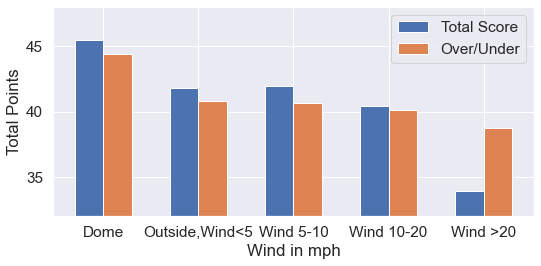

In [93]:
domed = dfall[dfall['dome'] == 1]
outside = dfall[dfall['dome'] == 0]

tpmean = (domed['Tot_Pts'].mean(),
          outside[(outside['Wind']<=5)]['Tot_Pts'].mean(),
          outside[((outside['Wind']>5) & (outside['Wind']<=10))]['Tot_Pts'].mean(),
          outside[((outside['Wind']>10) & (outside['Wind']<=20))]['Tot_Pts'].mean(),
          outside[(outside['Wind']>20)]['Tot_Pts'].mean())
oumean = (domed['Over_Under'].mean(),
          outside[(outside['Wind']<=5)]['Over_Under'].mean(),
          outside[((outside['Wind']>5) & (outside['Wind']<=10))]['Over_Under'].mean(),
          outside[((outside['Wind']>10) & (outside['Wind']<=20))]['Over_Under'].mean(),
          outside[(outside['Wind']>20)]['Over_Under'].mean())

fig10 = plt.figure(figsize=(8,4))
ax = fig10.add_subplot(1,1,1)

ind = np.arange(5)  # the x locations for the groups
width = 0.3  # the width of the bars

sns.set(font_scale=1.4)
_ = plt.bar(ind - width/2, tpmean, width, label='Total Score')
_ = plt.bar(ind + width/2, oumean, width, label='Over/Under')

# Add some text for labels, title and custom x-axis tick labels, etc.
_ = plt.ylabel('Total Points')
#_ = plt.title('Average Points by Location')
_ = plt.xticks(ind,labels=('Dome','Outside,Wind<5','Wind 5-10','Wind 10-20','Wind >20'))
_ = plt.xlabel('Wind in mph')
_ = plt.legend(loc='upper right')
_ = plt.ylim(32,48)
fig10.show()
fig10.tight_layout()


In [94]:
by_team = pd.DataFrame(index=teams.keys())
grouped_by_home = dfall.groupby(dfall['Home_Team'])
grouped_by_vis = dfall.groupby(dfall['Vis_Team'])
for key, item in grouped_by_home:
    by_team.loc[key,'Avg Home Team Score'] = round(item['H_Game'].mean(),3)
    by_team.loc[key,'Avg Home Total Score'] = round(item['Tot_Pts'].mean(),3)
for key,item in grouped_by_vis:
    by_team.loc[key,'Avg Vis Team Score'] = round(item['V_Game'].mean(),3)
    by_team.loc[key,'Avg Vis Total Score'] = round(item['Tot_Pts'].mean(),3)
by_team['Avg Team Score'] = (by_team['Avg Home Team Score'] + by_team['Avg Vis Team Score'])/2.0
by_team['Team Home - Vis'] = by_team['Avg Home Team Score'] - by_team['Avg Vis Team Score']
by_team['Total Home - Vis'] = by_team['Avg Home Total Score'] - by_team['Avg Vis Total Score']
by_team = by_team[['Avg Home Team Score','Avg Vis Team Score','Avg Team Score','Team Home - Vis',
                   'Avg Home Total Score','Avg Vis Total Score','Total Home - Vis']]
by_team.sort_values(by=['Avg Team Score'],ascending=False)

,Avg Home Team Score,Avg Vis Team Score,Avg Team Score,Team Home - Vis,Avg Home Total Score,Avg Vis Total Score,Total Home - Vis
Indianapolis Colts,27.500,25.862,26.6810,1.638,46.688,47.750,-1.062
New England Patriots,24.838,25.200,25.0190,-0.362,41.362,44.888,-3.526
Green Bay Packers,24.625,24.388,24.5065,0.237,42.788,47.250,-4.462
San Diego Chargers,25.850,23.000,24.4250,2.850,46.487,45.462,1.025
New Orleans Saints,23.325,24.262,23.7935,-0.937,46.087,47.438,-1.351
Philadelphia Eagles,24.412,22.562,23.4870,1.850,42.300,40.712,1.588
Denver Broncos,24.125,22.238,23.1815,1.887,43.675,45.200,-1.525
Minnesota Vikings,25.025,21.225,23.1250,3.800,44.612,46.362,-1.750
Kansas City Chiefs,25.150,20.525,22.8375,4.625,46.913,45.050,1.863
Pittsburgh Steelers,24.212,20.600,22.4060,3.612,41.163,38.388,2.775


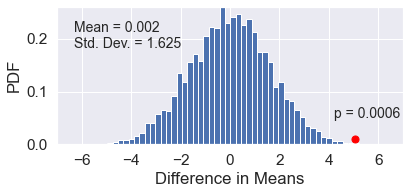

In [95]:
nor_home = dfall[dfall['Home_Team']=='New Orleans Saints']
nor_away = dfall[dfall['Vis_Team']=='New Orleans Saints']
nor_mean_diff = permuted(nor_home['H_Game'],nor_away['V_Game'],diff_of_means)

p = 1.0 - stats.percentileofscore(nor_mean_diff,5.075)/100

mu = np.mean(nor_mean_diff)
sd = np.std(nor_mean_diff)

ymax = 0.26
y1 = ymax
y2 = 0.0
fig = plt.figure(figsize=(6,3))
ax = fig.add_subplot(1,1,1)
_ = plt.hist(nor_mean_diff,bins=55,density=True,label='Seasonal mean Over%',zorder=1)
_ = plt.ylim(0,ymax)
_ = plt.xlim(-7,7)
ax.text(0.05,0.7,'Mean = {0:.3f}\nStd. Dev. = {1:.3f}'.format(mu,sd),transform=ax.transAxes,fontsize='small')
ax.text(4.2,0.05,'p = {:.4f}'.format(p),fontsize='small')
_ = plt.xlabel('Difference in Means')
_ = plt.ylabel('PDF')
_ = plt.scatter(5.075,0.01,marker='.',color='red',s=200,zorder=2)
fig.tight_layout()
fig.show()

In [97]:
import pingouin as pg
res = pg.ttest(ntot_home['Tot_Pts']>ntot_home['Over_Under'],(dfall['Tot_Pts']>dfall['Over_Under']).mean(),
              tail='one-sided')
print(res)

               T  dof     tail     p-val        CI95%   cohen-d   BF10  \
T-test  0.106244   79  greater  0.457829  [0.39, inf]  0.011878  0.248   

           power  
T-test  0.061839  


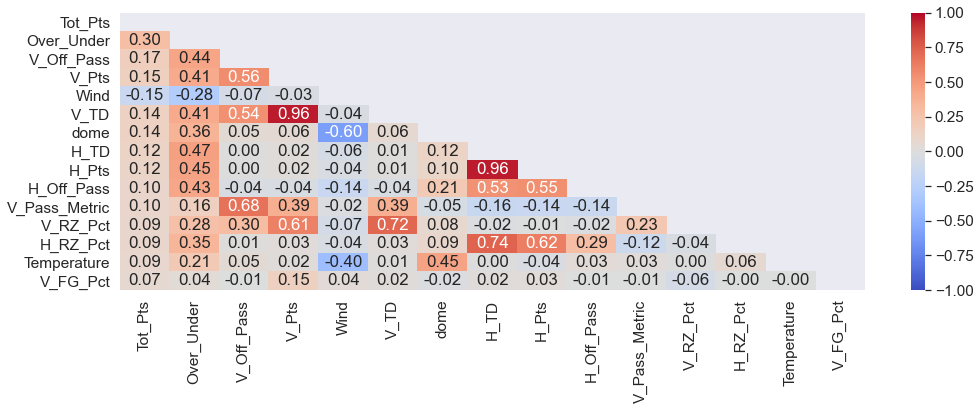

In [99]:
fig14 = plt.figure(figsize=(15,6))
ax = fig14.add_subplot(1,1,1)
cols = X_show.drop(['Home_Team','Vis_Team','H_Game','V_Game'],axis=1).columns
corrs = [np.abs(X_show['Tot_Pts'].corr(X_show[col])) for col in cols]
sortcorr = sorted(corrs,reverse=True)
mapa = {ind:corrs.index(value) for ind,value in enumerate(sortcorr)}
newcols = [cols[mapa[ind]] for ind in range(len(cols))]

Top = X_show[newcols[0:15]]
mask = np.triu(Top.corr())
sns.set(font_scale=1.4)
sns.heatmap(Top.corr(),vmin=-1.0,center=0,vmax=1.0,mask=mask,
            annot=True,cmap='coolwarm',fmt='.2f')
fig14.tight_layout()
fig14.show()

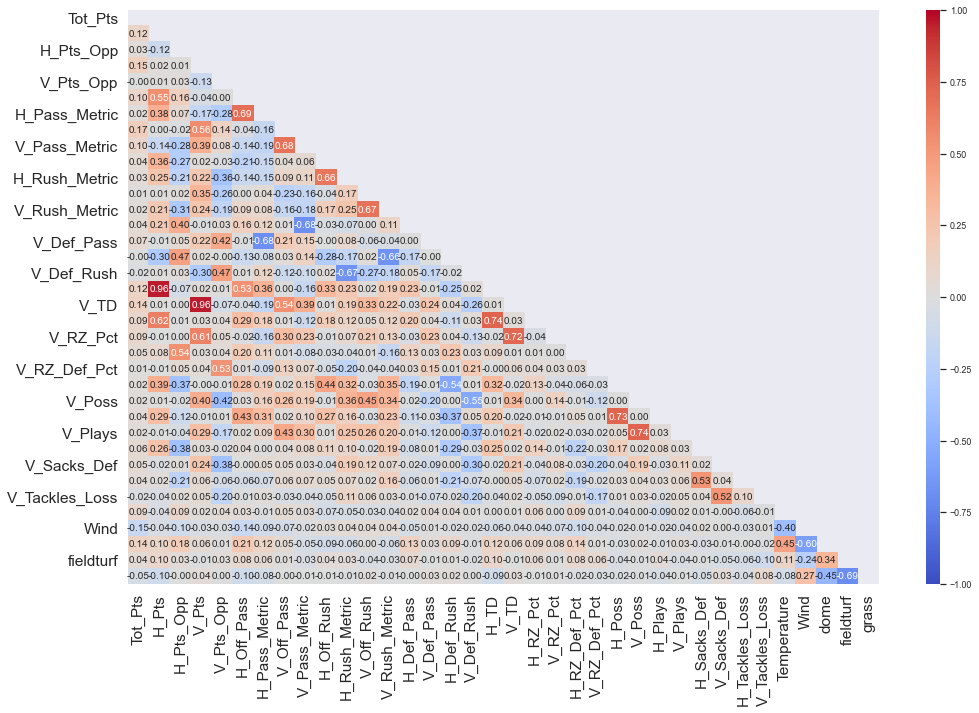

In [100]:
fig15 = plt.figure(figsize=(15,10))
ax = fig15.add_subplot(1,1,1)

dropped = ['Home_Team','Vis_Team','H_Game','V_Game','Over_Under']
                 
cols=X_show.columns.drop(dropped)

Stats=X_show[cols]
coeffs = Stats.corr()
moretodrop = []
for col in cols:
    if (col != 'Tot_Pts'):
        max_coef = coeffs.loc[col,np.abs(coeffs.loc[col]).rank(ascending=False) == 2].values[0] # neglect self-correlation
        if np.abs(max_coef) < 0.4: moretodrop.append(col)
coeffs = coeffs.drop(moretodrop).drop(moretodrop,axis=1)
mask = np.triu(coeffs)
sns.set(font_scale=0.8)
#sns.set(font_scale=1.0)
sns.heatmap(coeffs,vmin=-1.0,center=0,vmax=1.0,mask=mask,
            annot=True,cmap='coolwarm',cbar_kws={'aspect':40},fmt='.2f',annot_kws={"size": 10})
fig15.tight_layout()
fig15.show()

In [102]:
domed.Home_Team.value_counts()

St. Louis Rams        80
Minnesota Vikings     80
Detroit Lions         80
Atlanta Falcons       80
Indianapolis Colts    80
New Orleans Saints    74
Houston Texans        64
Arizona Cardinals     32
Dallas Cowboys         8
Buffalo Bills          2
Name: Home_Team, dtype: int64